In [136]:
import my_lib as my
import matplotlib.pyplot as plt
import numpy as np
import scipy as s
import pandas as pd
from scipy import stats
from math import log10, floor,pi,sqrt,tan

m=0.001
u=0.000001
n=0.000000001
p=0.000000000001
k=1000
M=1000000
G=1000000000
T=1000000000000

In [137]:
# Pt 0 Fluttuazioni laser
#Lettura
df0 = pd.read_csv('data_vuoto.csv')
t  = np.asarray(df0.iloc[:,0])
I  = np.asarray(df0.iloc[:,1])

In [138]:
mean = np.mean(I)
std = np.std(I)
sigma_relativa = std/mean
print('Incertezza Relativa Intensita =',sigma_relativa)

def sigma_Intensity2V(Int):
    return my.sqrt_sum(sigma_relativa*Int,0.0005*Int,3)

Incertezza Relativa Intensita = 0.005604276831073769


In [139]:
# Pt 1 funzioni e costanti
Z = 852     # mm 
sZ  = 3

def Lambda(x,Z,F,m): # nm
    L = x*F/(Z*m) *M  # M: normalizzazione L[nm]
    return L

def SigmaLambda(x,sx,Z,sZ,F,sF,m):
    dx = Lambda(sx,Z, F,m) 
    dF = Lambda( x,Z,sF,m) 
    dZ = F*x/(m*np.power(Z,2))*sZ *M
    sL = np.sqrt(np.power(dx,2) + np.power(dZ,2) + np.power(dF,2) )
    return sL

In [140]:
# Lettura 1
df1   = pd.read_csv('data1.csv')
m     = np.asarray(df1.iloc[:,0]) # m del minimo
F     = np.asarray(df1.iloc[:,1]) #fenditura
sF    = np.full(len(F),0.001) # sigma a caso

MAX = np.asarray(df1.iloc[:,7])
ArrX = np.asarray(df1.iloc[:,8:12])
ArrY = np.asarray(df1.iloc[:,3:7])
ArrsY = sigma_Intensity2V(ArrY)

#df1

#Array con i limiti per i parametri dei fit
bounds_min =[[0,0,30],
             [0,0,10],
             [0,7,10],
             [0,10.44,130],
             [0,9,50],
             [0,6.99,10],
             [0,10.10,100]]
bounds_max =[[100,100,60],
             [100,100,60],
             [10000,7.08,100],
             [10000,10.53,200],
             [10000,9.08,200],
             [10000,7.06,44],
             [10000,10.15,125]] 

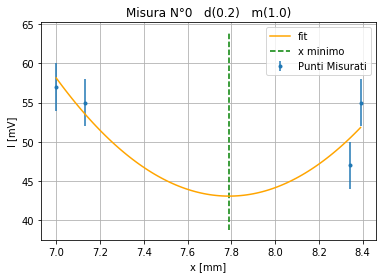

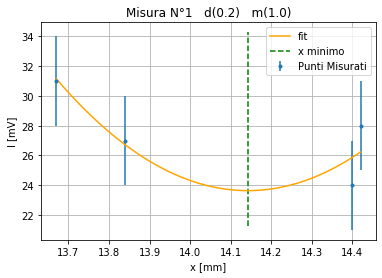

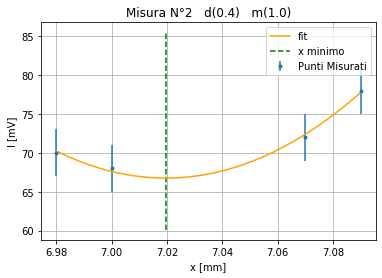

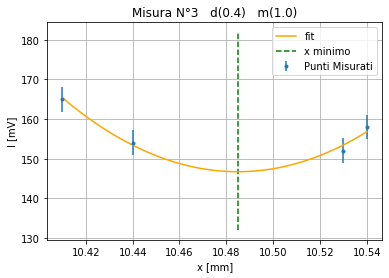

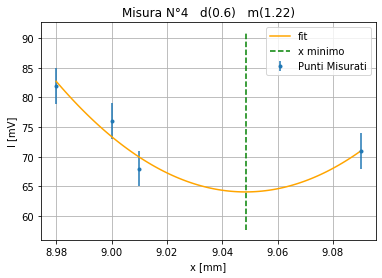

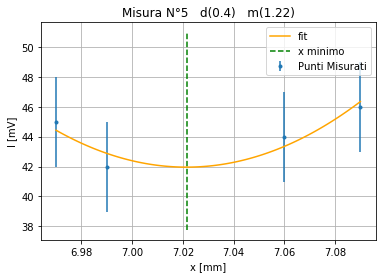

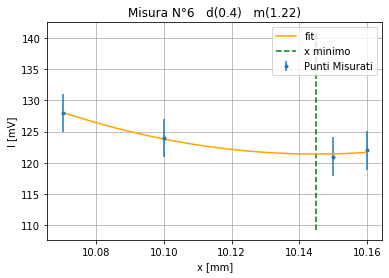

In [141]:
X_fit = np.asarray([])                        
X_min = np.asarray([])                        
sX_min = np.asarray([])
Array_L = np.asarray([])                         
Array_sL = np.asarray([])

def fit_func(x,a,b,c):
    return a*(x-b)**2 + c

for T in range(len(ArrX)):
    X  = ArrX[T]
    Y  = ArrY[T]
    sY = ArrsY[T]
     
    #Fit
    [a,b,c],pcov = s.optimize.curve_fit(fit_func,X,Y,sigma = sY,absolute_sigma = True,method = 'trf',bounds = (bounds_min[T],bounds_max[T]))
    [sa,sb,sc] = np.sqrt(np.diag(pcov))
    
    #Plot
    plt.errorbar(X,Y,sY, ls='', marker='.',label = 'Punti Misurati')
    
    x = np.linspace(np.min(X),np.max(X),100)
    y = fit_func(x,a,b,c)
    plt.plot(x,y,label = 'fit',color = 'orange')
    plt.vlines(b,ymin = 0.9*np.min(y),ymax = 1.1*np.max(y), label = 'x minimo',color = 'g',ls = '--')
    plt.title('Misura N°{}   d({})   m({})'.format(T,F[T],m[T]))
    plt.ylabel('I [mV]')
    plt.xlabel('x [mm]')
    plt.grid()
    plt.legend()
    plt.show()

    X_fit = np.append(X_fit,b)                        
    
    Value =  np.abs(b - MAX[T]) 
    sValue = sb
    X_min = np.append(X_min,Value)
    sX_min = np.append(sX_min,sValue)

    L = Lambda(Value,Z,F[T],m[T])
    sL = SigmaLambda(Value,sValue,Z,sZ,F[T],sF[T],m[T])

    Array_L = np.append(Array_L,L)                         
    Array_sL = np.append(Array_sL,sL)

In [142]:
Results = pd.DataFrame({'Xmin':X_min, 'sXmin':sX_min,'Lambda':Array_L,'sLambda':Array_sL})

L = np.sum(Array_L)/len(Array_L)
sL = my.sqrt_sum(Array_sL)/len(Array_sL)
print('L =',L,'+-',sL)

Cut = np.delete(Array_L,4)
sCut = np.delete(Array_sL,4)
L = np.sum(Cut)/len(Cut)
sL = my.sqrt_sum(sCut)/len(sCut)
print('senza la N°4 => L =',L,'+-',sL)

Results

L = 764.9168662302411 +- 5.9905078939543515
senza la N°4 => L = 720.0439792459296 +- 6.934965631289916


,Xmin,sXmin,Lambda,sLambda
0,3.110892,0.090110,730.256250,21.618926
1,3.242417,0.110361,761.130827,26.321245
2,1.260355,0.013769,591.715897,6.951097
3,2.204927,0.005140,1035.176907,5.080000
4,1.791569,0.005698,1034.154188,5.200780
5,1.718558,0.019552,661.339784,8.047819
6,1.404918,0.053688,540.644210,20.791765


In [143]:
# Pt 2 funzioni e costanti

L = 638
d = 0.4  # mm 
sd  = 0.05*d


def Beta(x,Z,d,L):
    B = pi*d*x/(L*Z) *M
    return B
def Intensity(B,I0):
    I = I0*np.power(np.sin(B)/B,2)
    return I

def SigmaBeta(x,sx,Z,sZ,d,sd,L,sL):
    dx = Beta(sx,Z, d,L)
    dd = Beta( x,Z,sd,L)
    dZ = pi*d*x/(L*np.power(Z,2))*sZ *M
    dL = pi*d*x/(Z*np.power(L,2))*sL *M
    sB = np.sqrt(np.power(dx,2) + np.power(dZ,2) + np.power(dd,2) + np.power(dL,2) ) 
    return sB

def SigmaIntensity(B,sB,I0,sI0):
    dB = 2*I0*np.sin(B)*( B*np.cos(B)-np.sin(B) )/np.power(B,3)*sB
    dI0 = Intensity(B,sI0)
    sI = np.sqrt( np.power(dB,2) + np.power(dI0,2) )
    return sI

print('Z = ',Z,' mm')
print('d = ',d,' mm')
print('L = ',L,' nm')

Z =  852  mm
d =  0.4  mm
L =  638  nm


In [144]:
# Parametri ricavati da fit 
x_offset = 6.0006
I0 = 7065.942      # misurata nel massimo
sI0 = sigma_Intensity2V(I0)

In [145]:
# Lettura 2
df2 = pd.read_csv('data2.csv')
xmis  = np.asarray(df2.iloc[:,0]) - x_offset
Imis  = np.asarray(df2.iloc[:,1])

sxmis = np.full(41,0.0) # sigma a caso
sImis = sigma_Intensity2V(Imis)

In [146]:
#Andamento Teorico
x = np.linspace(-6,6,1000) #mm
sx = np.zeros(1000)

B  = Beta(x,Z,d,L)
sB = SigmaBeta(x,sx,Z,sZ,d,sd,L,sL)

I  = Intensity(B,I0) 
sI = SigmaIntensity(B,sB,I0,sI0)

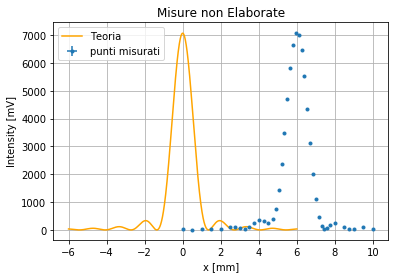

In [147]:
#Grafico intensità

plt.plot(x,I,color='orange',label='Teoria') #Teoria
plt.errorbar(xmis + x_offset,Imis, yerr=sImis, xerr=0, ls='', marker='.', label='punti misurati') #Misurati


plt.title('Misure non Elaborate')
plt.xlabel('x [mm]')
plt.ylabel('Intensity [mV]')
plt.grid()
plt.legend()

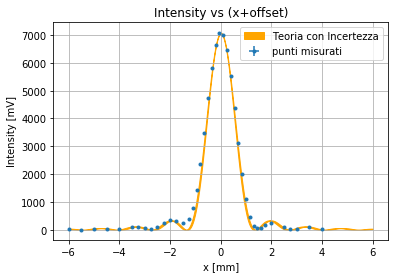

In [148]:
#Teorico Incertezza

plt.errorbar(xmis,Imis, yerr=sImis, xerr=0, ls='', marker='.', label='punti misurati')

plt.fill_between(x,I+sI/2,y2 = I-sI/2, color = 'orange',label = 'Teoria con Incertezza')


#plt.ylim(0,1000)
plt.title('Intensity vs (x+offset)')
plt.xlabel('x [mm]')
plt.ylabel('Intensity [mV]')
plt.grid()
plt.legend()

In [149]:
#Chi quadro

Xdata  = xmis
sXdata = sxmis

Ydata = Imis
sYdata = sImis

Yexp  = Intensity(Beta(Xdata,Z,d,L),I0)
sYexp = SigmaIntensity( Beta(Xdata,Z,d,L), SigmaBeta(Xdata,sXdata,Z,sZ,d,sd,L,sL), I0,sI0)

#Yerror = sImis
Yerror = np.sqrt( np.power(sYdata,2) + np.power(sYexp,2) ) # Sta cosa non so troppo convinto che è giusta ma stica

chi2 = np.sum( ( (Yexp - Ydata)/Yerror )**2 )
print('chi2 = ',chi2)

chi2 =  133.088148271258


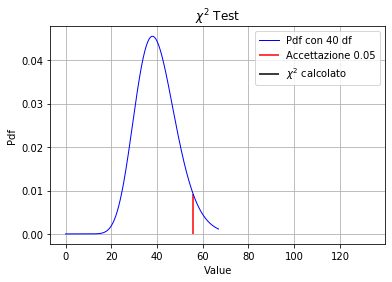

0

In [150]:
#Grafico del fit
my.chi_graph(chi2,r'$\chi^2$ calcolato',40)

In [151]:
# Pt 3 funzini e costanti

def Capello(L,Z,A):
    M=1000000 
    return Z*L/(A*M)
def SigmaCapello(L,Z,A,sL,sZ,sA):
    dL = Capello(sL, Z,A)
    dZ = Capello( L,sZ,A)
    dA = -Z*L/(M*A**2) *sA
    return my.sqrt_sum(dL,dZ,dA)

In [152]:
#Lettura 2
df3 = pd.read_csv('data3.csv')
m  = np.asarray(df3.iloc[:,0])
Min  = np.asarray(df3.iloc[:,1]) #in mm
sMin = np.full(len(Min),1)      #in mm
df3

,m,x[mm]
0,-6,7.289
1,-5,15.260
2,-4,22.240
3,-3,29.790
4,-2,37.130
5,-1,44.110
6,1,59.110
7,2,66.240
8,3,73.820
9,4,81.390


In [153]:
#Fit
def fit(x,m,c):
    return m*x + c

[A,c],pcov = s.optimize.curve_fit(fit,m,Min,sigma = sMin,absolute_sigma = True)
[sA,sc] = np.sqrt(np.diag(pcov))


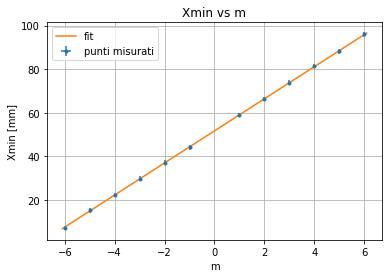

In [154]:
x=np.linspace(-6.1,6.1,100)
plt.errorbar(m,Min, yerr=sMin, xerr=0, ls='', marker='.', label='punti misurati')
plt.plot(x,fit(x,A,c),label='fit')
plt.title('Xmin vs m')
plt.ylabel('Xmin [mm]')
plt.xlabel('m')
plt.grid()
plt.legend()

In [155]:
Cap = Capello(L,Z,A)
sCap = SigmaCapello(L,Z,A,sL,sZ,sA)


print('Z = ',Z,' mm')
print('L = ',L,' nm')
print('=> F = ',Cap,'+-',sCap,' mm')

Z =  852  mm
L =  638  nm
=> F =  0.07394232054315385 +- 0.0011267954373886215  mm
